# Visualising Data from Copernicus Marine Service

Refactoring code by M. Sadien and R. Louis of the Mauritius Oceanography Institute. Updated code leverages the copernicusmarine library, which handily manages login as well as data selection + downloading.

## 1. Imports

In [51]:
import pyinterp
import pyinterp.fill
import pyinterp.backends.xarray

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

import numpy as np
import pyinterp
import xarray as xr

import copernicusmarine as cm

## 2. Data retrieval from Copernicus Servers using API key

Uncomment and run the cell below to create a config file that saves to your current directory, storing your API username and password. This allows you to run copernicus data retrieval queries like subset, get or open_dataset without keying in your credentials every time. Very efficient.

In [ ]:
#cm.login() 

Now you can run the ``subset`` command to select data within a specific timeframe and geographic bounds. I've input values correponding to Seychelles but you can just as easily define the boundary of a polygon encapsulating the area of concern to you. I've also set the maximum depth to 1 as I'm only interested in surface ocean data. This also conveniently reduces the file size by several orders of magnitude. 

Note that if you run the uncommented version of this cell, you will be prompted to confirm whether the netCDF files corresponding to your query are correct before downloading. Simply follow the prompt and open your file explorer or terminal and confirm the data has been downloaded to the specified directory.

In [75]:
cm.subset(
  dataset_id="cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m",
  variables=["uo", "vo"],
  minimum_longitude=40.77,
  maximum_longitude=60.51,
  minimum_latitude=-12.22,
  maximum_latitude=-3.44,
  start_datetime="2024-11-09T00:00:00",
  end_datetime="2022-11-16T23:59:59",
  minimum_depth=0,
  maximum_depth=1,
  output_filename = "cmems_sey_09_nov.nc",
  output_directory = "current_data"
)

INFO - 2024-11-08T05:58:10Z - Dataset version was not specified, the latest one was selected: "202406"
INFO - 2024-11-08T05:58:10Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-11-08T05:58:14Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-11-08T05:58:17Z - Downloading using service arco-geo-series...
INFO - 2024-11-08T05:58:21Z - <xarray.Dataset> Size: 200kB
Dimensions:    (depth: 1, latitude: 105, longitude: 237, time: 1)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 420B -12.17 -12.08 -12.0 ... -3.583 -3.5
  * longitude  (longitude) float32 948B 40.83 40.92 41.0 ... 60.33 60.42 60.5
  * time       (time) datetime64[ns] 8B 2024-11-09
Data variables:
    uo         (time, depth, latitude, longitude) float32 100kB dask.array<chunksize=(1, 1, 105, 237), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 100kB dask.array<chunksize=(1, 1, 105, 23

  n


Abort


## 2. Reading the downloaded netCDF file

In [19]:
data = xr.open_dataset('current_data/CMEMS_SEY_currents_Nov2024_(1).nc')

In [20]:
data

<xarray.Dataset> Size: 200kB
Dimensions:    (depth: 1, latitude: 105, longitude: 237, time: 1)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 420B -12.17 -12.08 -12.0 ... -3.583 -3.5
  * longitude  (longitude) float32 948B 40.83 40.92 41.0 ... 60.33 60.42 60.5
  * time       (time) datetime64[ns] 8B 2024-11-08
Data variables:
    uo         (time, depth, latitude, longitude) float32 100kB ...
    vo         (time, depth, latitude, longitude) float32 100kB ...
Attributes:
    Conventions:               CF-1.8
    area:                      Global
    contact:                   https://marine.copernicus.eu/contact
    credit:                    E.U. Copernicus Marine Service Information (CM...
    institution:               Mercator Ocean International
    licence:                   http://marine.copernicus.eu/services-portfolio...
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    references:                http://marine.copernicus.eu
    source:                    MOI GLO12
    title:                     daily mean fields from Global Ocean Physics An...
    copernicusmarine_version:  1.3.4

In [26]:
data.variables['vo']

<xarray.Variable (time: 1, depth: 1, latitude: 105, longitude: 237)> Size: 100kB
array([[[[-1.16446 , ..., -0.038041],
         ...,
         [ 0.903458, ...,  0.029366]]]], dtype=float32)
Attributes:
    cell_methods:   area: mean
    long_name:      Northward velocity
    standard_name:  northward_sea_water_velocity
    unit_long:      Meters per second
    units:          m s-1
    valid_max:      5.0
    valid_min:      -5.0

Now we can extract our data into numpy arrays in order to interpolate and plot, easily

In [29]:
lat = data.variables['latitude'].values
lon = data.variables['longitude'].values
timestamp = data.variables['time'].values
depth = data.variables['depth'].values
vy = data.variables['vo'].values
ux = data.variables['uo'].values

data.close() # close the file handle to avoid running out of file handles

Set up the original grid

In [73]:
x_axis = pyinterp.Axis(lon, is_circle=False)
y_axis = pyinterp.Axis(lat)

# create a new set of much more granular grid points for the interpolation. 
# This is effectively the same grid rendered to a much higher resolution.
step = 1/24

x_lon_i = np.arange(np.amin(lon),np.amax(lon),step)
y_lat_i = np.arange(np.amin(lat),np.amax(lat),step)

xx_lon_i, yy_lat_i = np.meshgrid(x_lon_i,y_lat_i,indexing='ij')

Plot interpolated data

<Figure size 3000x3000 with 0 Axes>

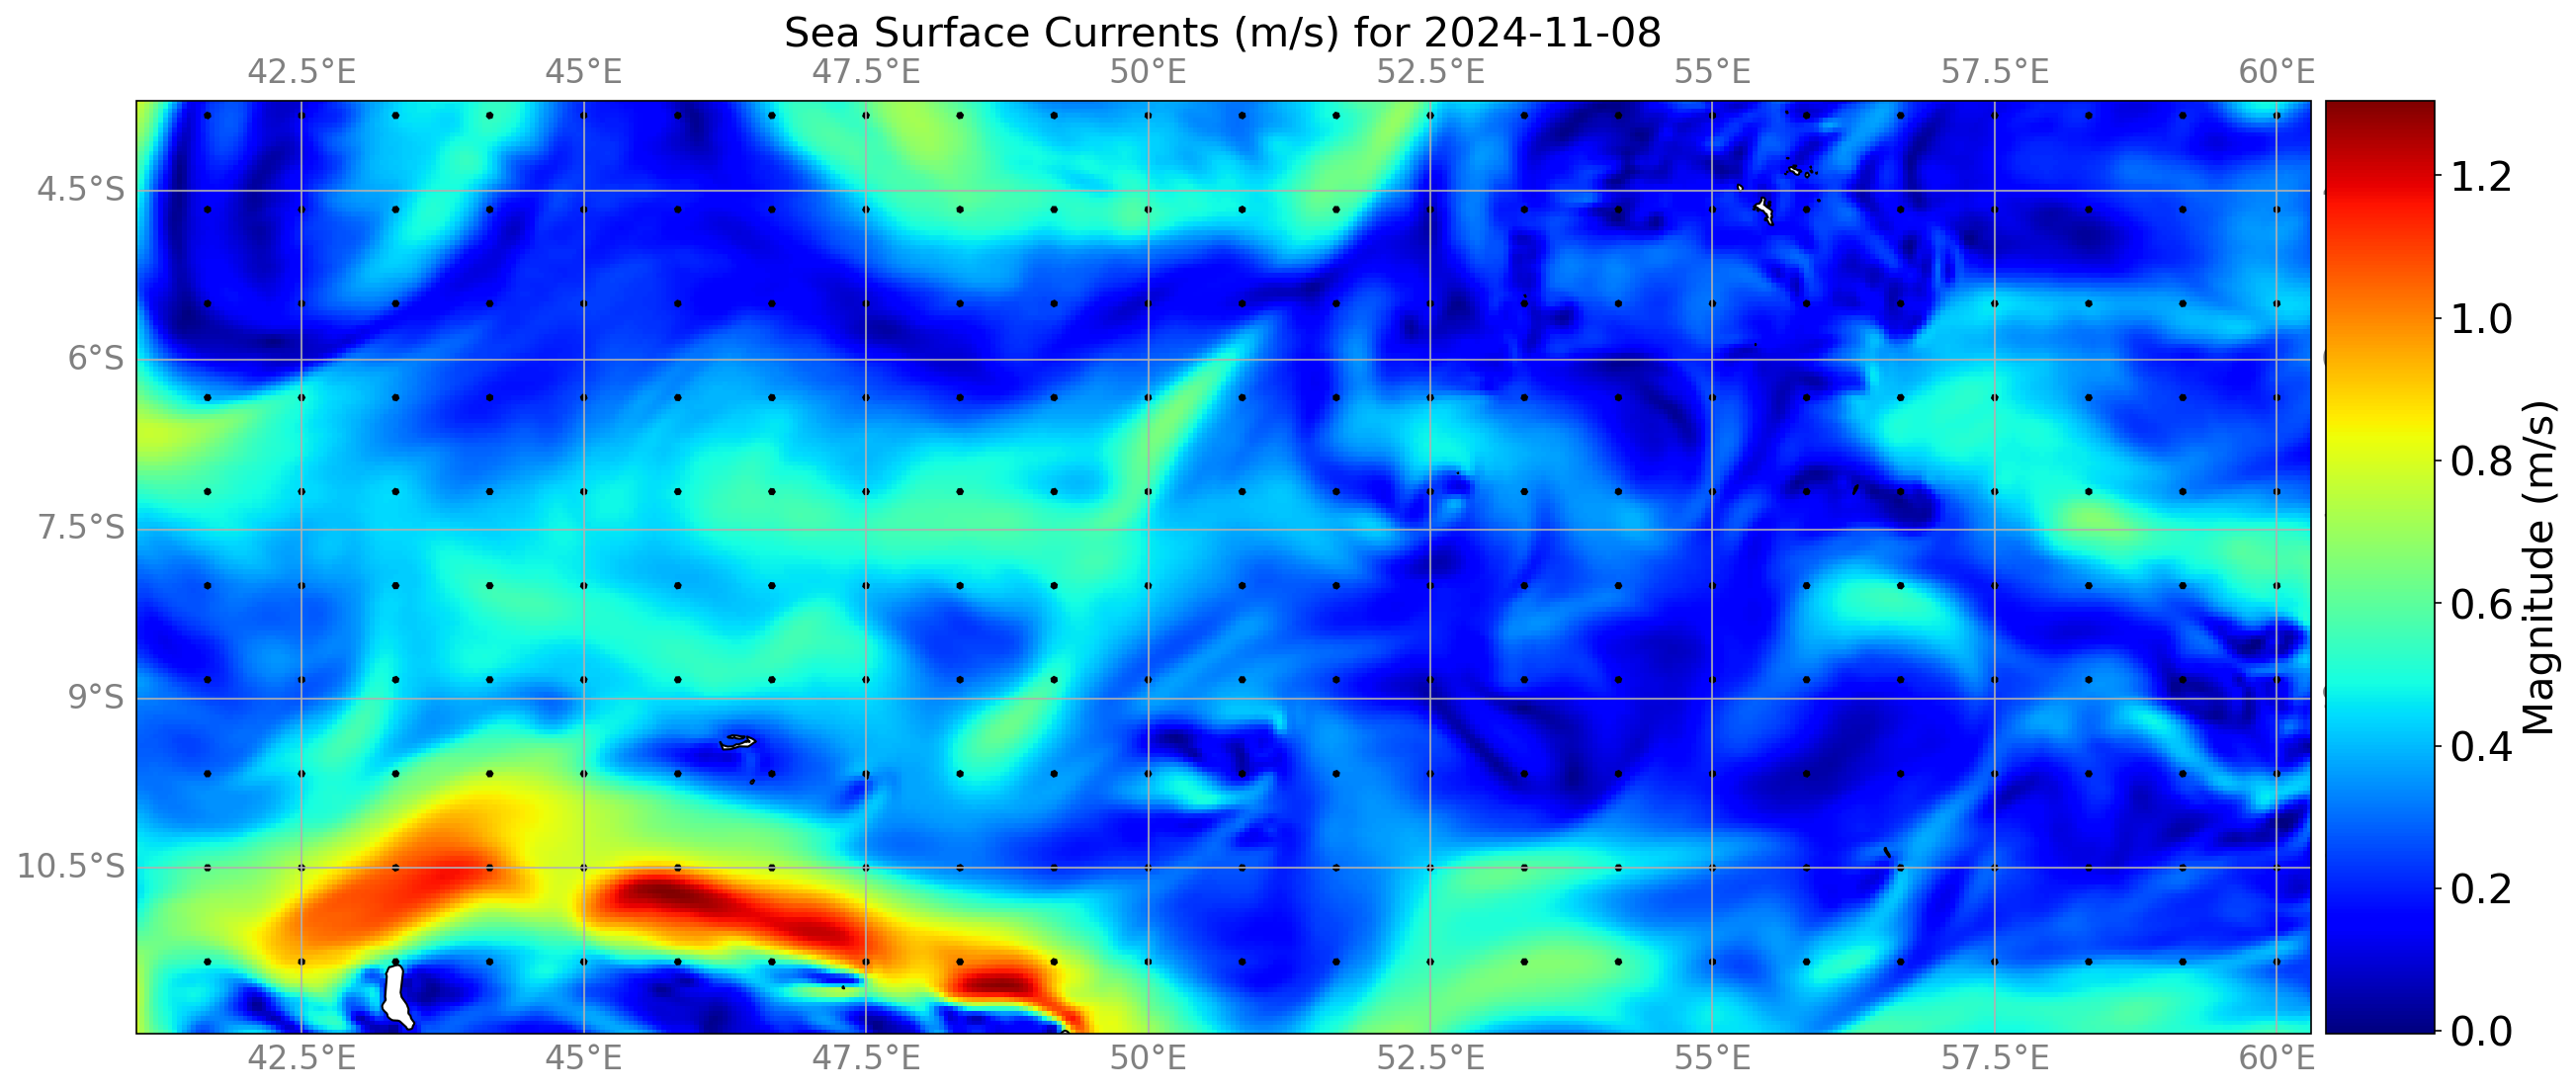

In [77]:
for i in range(ux.shape[0]):
    # Create the figure handle
    fig = plt.figure(figsize=(20,20), dpi=150)
    gs  = gridspec.GridSpec(1,1)
   # Create a variable m with a subplot at position 0,0m with the projection cattered by cartopy ccrs module/method,
    fig, ax = plt.subplots(1, 1, figsize=(20,20), dpi=150,
                       subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Calculate the interpolated values
    mag = np.sqrt(ux[i, 0,:, :]*ux[i, 0,:, :] + vy[i, 0,:, :]*vy[i, 0,:, :])    
    
    mag_grid = pyinterp.Grid2D(x_axis, y_axis, mag.T)
    filled_mag_grid_loess = pyinterp.Grid2D(x_axis, y_axis, pyinterp.fill.loess(mag_grid, nx=3, ny=3)) 
    mag_interp_bic = pyinterp.bicubic( filled_mag_grid_loess, xx_lon_i.flatten(), 
                                      yy_lat_i.flatten(), nx=3, ny=3).reshape(xx_lon_i.shape)
   
    ux_grid = pyinterp.Grid2D(x_axis, y_axis, ux[i, 0,:, :].T)
    filled_ux_grid_loess = pyinterp.Grid2D(x_axis, y_axis, pyinterp.fill.loess(ux_grid, nx=3, ny=3)) 
    ux_interp_bic = pyinterp.bicubic( filled_ux_grid_loess, xx_lon_i.flatten(), 
                                     yy_lat_i.flatten(), nx=3, ny=3).reshape(xx_lon_i.shape)
  

    
    vy_grid = pyinterp.Grid2D(x_axis, y_axis, vy[i, 0,:, :].T)
    filled_vy_grid_loess = pyinterp.Grid2D(x_axis, y_axis, pyinterp.fill.loess(vy_grid, nx=3, ny=3)) 
    vy_interp_bic = pyinterp.bicubic( filled_vy_grid_loess, xx_lon_i.flatten(), 
                                     yy_lat_i.flatten(), nx=3, ny=3).reshape(xx_lon_i.shape)
        
    # plot the data
    p1 = plt.pcolormesh(xx_lon_i,yy_lat_i,mag_interp_bic,
                        cmap=plt.cm.jet,zorder=-1)
    

    # adding coastlines
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='white', name='coastline')
    ax.add_feature(coast, edgecolor='black')
    
    
    q1 = plt.quiver(xx_lon_i[skip], yy_lat_i[skip], 
                    ux_interp_bic[skip], vy_interp_bic[skip],zorder=1,scale=20,scale_units="inches")

    g1 = ax.gridlines(draw_labels = True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    g1.xlabel_style = {'size': 16, 'color': 'gray'}
    g1.ylabel_style = {'size': 16, 'color': 'gray'}

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

    fig.add_axes(ax_cb)
    cbar = fig.colorbar(p1, orientation='vertical', cax=ax_cb)
    cbar.ax.tick_params(labelsize=20)

    # adjust boundaries of the plot
    ax.set_xlim([lon.min() + 0.2, lon.max() - 0.2])
    ax.set_ylim([lat.min() + 0.2, lat.max() - 0.2])

    cbar.set_label('Magnitude (m/s)',fontsize=20)
    ax.set_title('Sea Surface Currents (m/s) for'+' {}'.format(np.datetime_as_string(timestamp[i],unit="D")),fontsize=20)
